In [2]:
import os
import random
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
#pip install split-folders
#import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.densenet import (DenseNet121,
                                                    preprocess_input)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import (BatchNormalization, Dense,
                                     Dropout, Flatten, Input)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = 'tdata'



DATASET_PATH = 'tdata/'
dir_list = os.listdir(DATASET_PATH)
print(dir_list)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [4]:
num_of_images = []
for root, dirs, files in os.walk(DATASET_PATH):
    if root == DATASET_PATH: continue
    print('{}: {}'.format(os.path.basename(root), len(files)))
    num_of_images.append(len(files))

Tomato___Bacterial_spot: 42
Tomato___Early_blight: 42
Tomato___healthy: 42
Tomato___Late_blight: 42
Tomato___Leaf_Mold: 42
Tomato___Septoria_leaf_spot: 42
Tomato___Spider_mites Two-spotted_spider_mite: 42
Tomato___Target_Spot: 42
Tomato___Tomato_mosaic_virus: 42
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 42


path: tdata\Tomato___Bacterial_spot\0fac0401-b9dc-49a0-9011-2cd3eb906107___GCREC_Bact.Sp 3144.JPG
size: (256, 256)
mode: RGB
format: JPEG


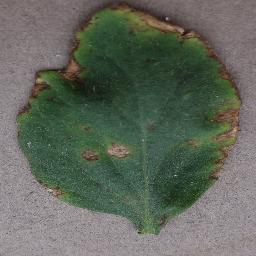

In [5]:
SEED = 123
random.seed(SEED)
rand_img = Image.open(random.choice(glob(DATASET_PATH + '/**/*')))

print('path:', rand_img.filename)
print('size:', rand_img.size)
print('mode:', rand_img.mode)
print('format:', rand_img.format)
display(rand_img)

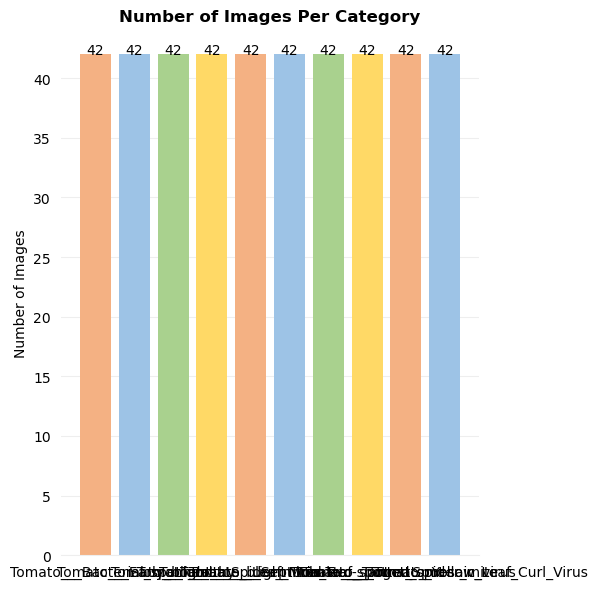

In [6]:
# Plot the number of images per subdirectory
x_coord = np.arange(len(dir_list))
colors = ['#f4b183', '#9dc3e6', '#a9d18e', '#ffd966']

fig, ax = plt.subplots(facecolor='white', figsize=(6,6))
ax.bar(x_coord, num_of_images, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#EEEEEE')

ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

plt.xticks(x_coord, dir_list)
ax.tick_params(bottom=False, left=False)

plt.title('Number of Images Per Category', fontweight='bold')
plt.ylabel('Number of Images')

for i in range(len(x_coord)):
    plt.text(i, num_of_images[i], num_of_images[i], ha='center')

plt.tight_layout()
plt.savefig('bar_chart.png', dpi=200)
plt.show()

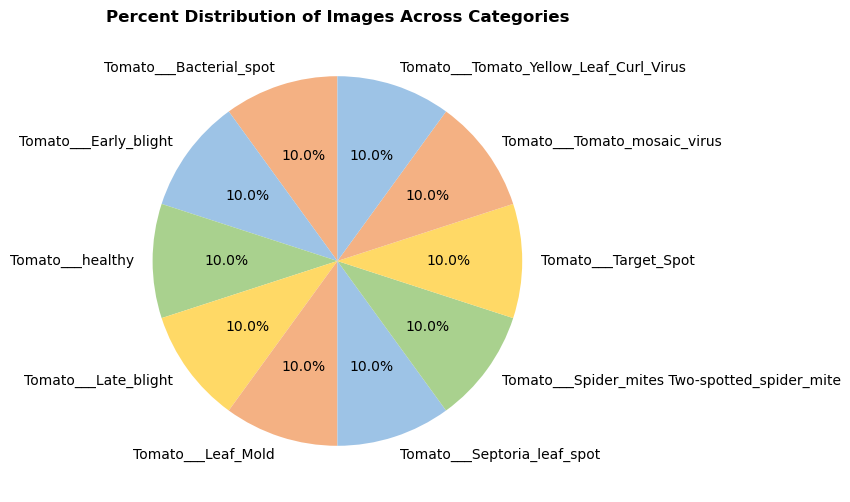

In [7]:
# Plot the percent distribution of images across subdirectories
plt.figure(facecolor='white', figsize=(6,6))
plt.pie(num_of_images,
        labels=dir_list,
        colors=colors,
        autopct='%.1f%%',
        startangle=90)
plt.title('Percent Distribution of Images Across Categories', fontweight='bold')
plt.savefig('pie_chart.png', dpi=200)
plt.show()

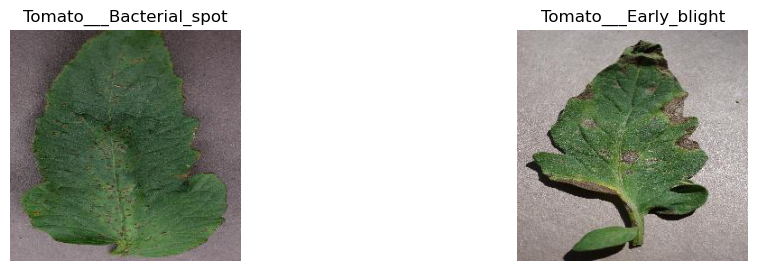

In [8]:
# Display random images, one from each category
plt.figure(facecolor='white', figsize=(12,3))
for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    path = random.choice(glob(DATASET_PATH + '/' + dir_list[i] + '/*'))
    plt.imshow(Image.open(path), cmap='gray')
    plt.title(dir_list[i])
    plt.axis('off')
plt.savefig('random_images.png', dpi=200)
plt.show()

In [9]:
# Split the dataset folder into test, train, and val folders
OUTPUT_PATH = 'dataset_subsets1'
if not os.path.exists(OUTPUT_PATH):
    splitfolders.ratio(DATASET_PATH, OUTPUT_PATH, SEED, (.7, .1, .2))

In [10]:
IMG_DIMS = 100
TARGET_SIZE = (IMG_DIMS, IMG_DIMS)
COLOR_MODE = 'rgb'
CLASS_MODE = 'categorical'
BATCH_SIZE = 16

In [11]:
#data preprocessing
TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True)
train_gen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 290 images belonging to 10 classes.


In [12]:
# Take the path to the val folder and generate batches of data
VAL_PATH = os.path.join(OUTPUT_PATH, 'val')
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    seed=SEED)

Found 40 images belonging to 10 classes.


In [13]:
# Take the path to the train folder and generate batches of data
TEST_PATH = os.path.join(OUTPUT_PATH, 'test')
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    color_mode=COLOR_MODE,
    class_mode=CLASS_MODE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 90 images belonging to 10 classes.


In [14]:
print(train_gen.directory)
print(val_gen.directory)
print(test_gen.directory)

dataset_subsets1\train
dataset_subsets1\val
dataset_subsets1\test


In [15]:
print(train_gen.class_indices)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [16]:
# Print the shapes of the first training batch tuple
images, labels = next(iter(train_gen))
print('images shape:', images.shape)  # (batch_size, *target_size, channels)
print('labels shape:', labels.shape)  # (batch_size, num_classes)

images shape: (16, 100, 100, 3)
labels shape: (16, 10)


In [17]:
# in the input layer it extracts the features and processed
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_DIMS, IMG_DIMS, 3)),
    input_shape=(IMG_DIMS, IMG_DIMS, 3))

29084464/29084464 [==============================] - 4s 0us/step


In [18]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Build the modified DenseNet121 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 batch_normalization (BatchN  (None, 9216)             36864     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              9438208   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [21]:
# Define hyperparameters
EPOCHS = 10
ETA = 0.0001

In [22]:
METRICS = ['categorical_accuracy', Precision(), Recall()]

In [23]:
# Compile the model
model.compile(optimizer=Adam(ETA),
              loss='categorical_crossentropy',
              metrics=METRICS)

In [24]:
# Create a learning rate scheduler callback
def scheduler(epoch):
    if epoch > 19:
        return ETA * 0.1
    else:
        return ETA
callback = LearningRateScheduler(scheduler)

In [25]:
# Estimate class weights for the unbalanced dataset
cls_wt = compute_class_weight(class_weight='balanced',
                              classes=np.unique(train_gen.labels),
                              y=train_gen.labels)
class_weight = {0: cls_wt[0], 1: cls_wt[1],2: cls_wt[2], 3: cls_wt[3],4: cls_wt[4], 5: cls_wt[5],6: cls_wt[6], 7: cls_wt[7], 8: cls_wt[8], 9: cls_wt[9]}
print(class_weight)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}


In [26]:
# Train the model
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    callbacks=callback,
                    validation_data=val_gen,
                    class_weight=class_weight)

Epoch 1/10
19/19 [==============================] - 45s 1s/step - loss: 2.6099 - categorical_accuracy: 0.1586 - precision: 0.1515 - recall: 0.0172 - val_loss: 2.4493 - val_categorical_accuracy: 0.2750 - val_precision: 0.1111 - val_recall: 0.0250 - lr: 1.0000e-04
Epoch 2/10
19/19 [==============================] - 15s 780ms/step - loss: 2.1102 - categorical_accuracy: 0.2828 - precision: 0.4130 - recall: 0.0655 - val_loss: 2.1226 - val_categorical_accuracy: 0.3000 - val_precision: 0.2727 - val_recall: 0.0750 - lr: 1.0000e-04
Epoch 3/10
19/19 [==============================] - 15s 787ms/step - loss: 1.7497 - categorical_accuracy: 0.3621 - precision: 0.5763 - recall: 0.1172 - val_loss: 1.7251 - val_categorical_accuracy: 0.3750 - val_precision: 0.5000 - val_recall: 0.1750 - lr: 1.0000e-04
Epoch 4/10
19/19 [==============================] - 15s 770ms/step - loss: 1.4763 - categorical_accuracy: 0.4655 - precision: 0.7619 - recall: 0.2207 - val_loss: 1.4957 - val_categorical_accuracy: 0.4250 -

In [27]:
def plot_metric_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-axis label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig(y_label + '.png', dpi=200)
    plt.show()

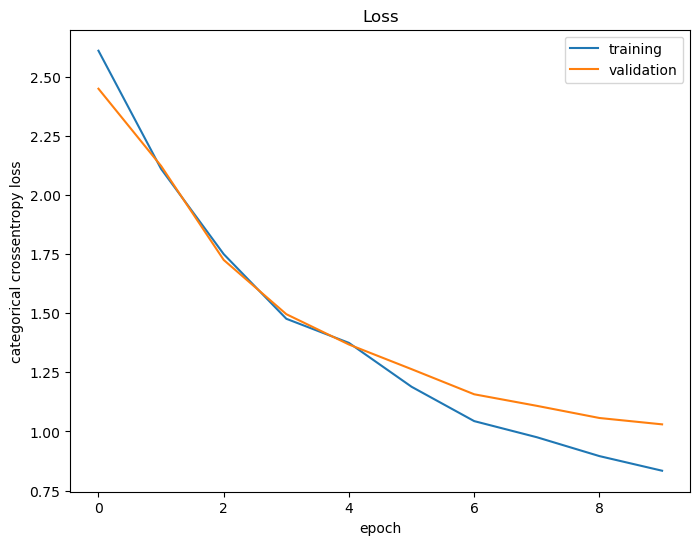

In [28]:
# Visualize loss history
plot_metric_history(metric='loss',
                    val_metric='val_loss',
                    y_label='categorical crossentropy loss',
                    title='Loss')

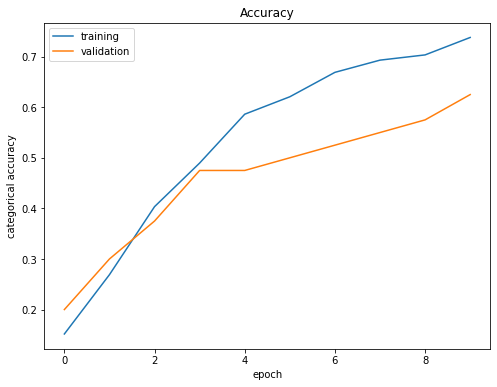

In [30]:
# Visualize accuracy history
plot_metric_history(metric='categorical_accuracy',
                    val_metric='val_categorical_accuracy',
                    y_label='categorical accuracy',
                    title='Accuracy')

In [29]:
# Print metrics values for the model in test mode
result = model.evaluate(test_gen)
dict(zip(model.metrics_names, result))

6/6 [==============================] - 4s 567ms/step - loss: 0.8956 - categorical_accuracy: 0.7222 - precision: 0.8030 - recall: 0.5889


{'loss': 0.8956003189086914,
 'categorical_accuracy': 0.7222222089767456,
 'precision': 0.8030303120613098,
 'recall': 0.5888888835906982}

In [30]:
predictions = model.predict(test_gen)

6/6 [==============================] - 9s 552ms/step


In [31]:
# Initialize true and predicted label values
y_true = test_gen.labels
y_pred = np.argmax(predictions, axis=1)

In [32]:
# Build a text report showing the main classification metrics
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.50      0.44      0.47         9
           2       0.83      0.56      0.67         9
           3       0.83      0.56      0.67         9
           4       0.67      0.67      0.67         9
           5       0.54      0.78      0.64         9
           6       1.00      0.67      0.80         9
           7       1.00      1.00      1.00         9
           8       0.75      1.00      0.86         9
           9       0.50      0.67      0.57         9

    accuracy                           0.72        90
   macro avg       0.75      0.72      0.72        90
weighted avg       0.75      0.72      0.72        90



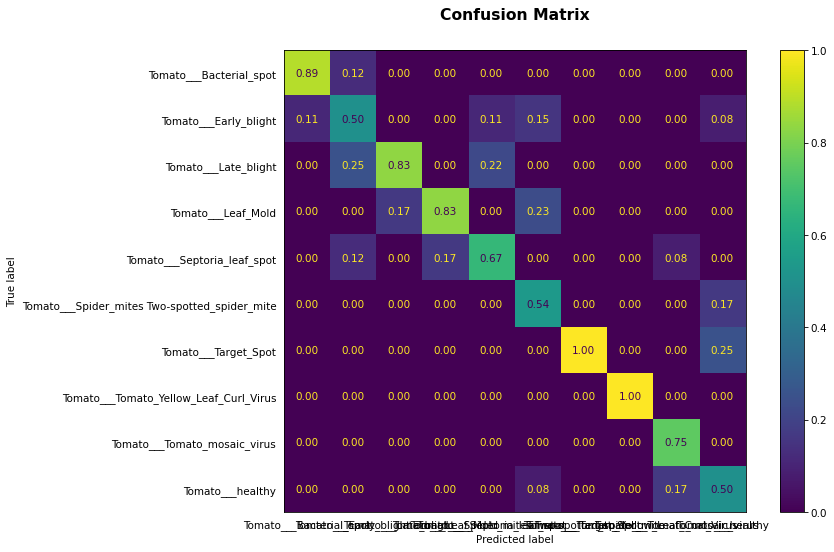

In [33]:
# Plot a confusion matrix given true and predicted labels
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=75)
fig = ConfusionMatrixDisplay.from_predictions(y_true,
                                              y_pred,
                                              display_labels=test_gen.class_indices,
                                              include_values=True,
                                              normalize='pred',
                                              values_format='.2f',
                                              cmap='viridis',
                                              ax=ax)
plt.tick_params(left=False, bottom=False)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=30)
#plt.xticks()
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()

In [34]:
model.save_weights("densenet121.h5")

In [35]:
filepath="densenet121.hdf5"
model.save(filepath)

In [36]:
from tensorflow.keras.models import load_model
classifier = load_model('densenet121.hdf5')

In [39]:
def predict(image_path):
    from skimage import io
    from keras.preprocessing import image
    #path='imbalanced/Scratch/Scratch_400.jpg'
    import tensorflow as tf

    img = tf.keras.utils.load_img(image_path, grayscale=False, target_size=(100, 100))
    show_img=tf.keras.utils.load_img(image_path, grayscale=False, target_size=(100, 100))
    disease_class = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
    
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    #x = np.array(x, 'float32')
    x /= 255

    custom = classifier.predict(x)
    print(custom[0])



    #x = x.reshape([64, 64]);

    #plt.gray()
    plt.imshow(show_img)
    plt.show()

    a=custom[0]
    ind=np.argmax(a)

    print('Prediction:',disease_class[ind])
    return disease_class[ind]


1/1 [==============================] - 5s 5s/step
[0.52504724 0.03529298 0.0434766  0.17230482 0.02673788 0.02463321
 0.00928185 0.09030776 0.02488063 0.04803702]


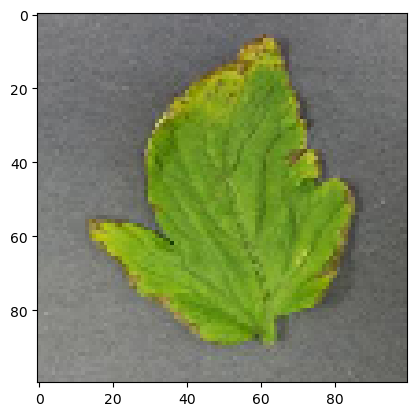

Prediction: Tomato___Bacterial_spot


'Tomato___Bacterial_spot'

In [40]:
predict('t.jpg')

1/1 [==============================] - 0s 142ms/step
[0.09254455 0.03796408 0.12163829 0.02401013 0.28904492 0.00825594
 0.04971759 0.16842067 0.18312143 0.02528235]


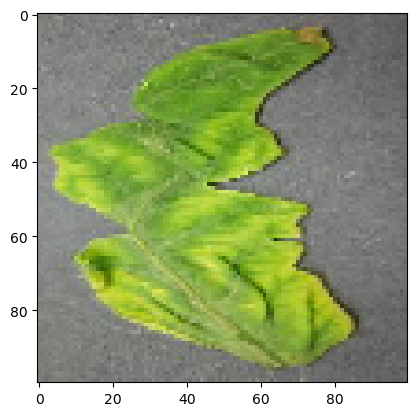

Prediction: Tomato___Leaf_Mold


'Tomato___Leaf_Mold'

In [41]:
predict('t1.jpg')

1/1 [==============================] - 0s 145ms/step
[0.10752766 0.0376937  0.03253224 0.45770022 0.00831848 0.03722559
 0.0129713  0.10687171 0.08078045 0.11837868]


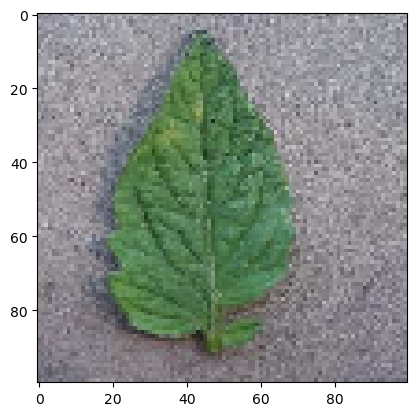

Prediction: Tomato___Late_blight


'Tomato___Late_blight'

In [42]:
predict('t2.jpg')

1/1 [==============================] - 0s 137ms/step
[0.00943718 0.04126433 0.40494093 0.19762081 0.04730247 0.19609444
 0.00603451 0.01727833 0.0678796  0.01214736]


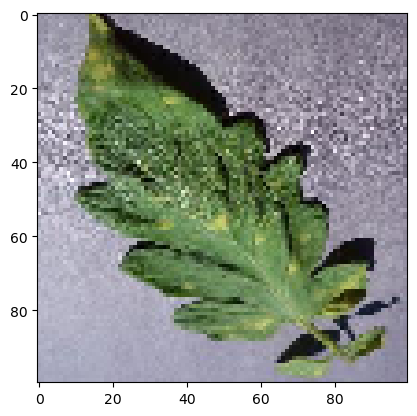

Prediction: Tomato___healthy


'Tomato___healthy'

In [43]:
predict('t3.jpg')

1/1 [==============================] - 0s 142ms/step
[0.01147541 0.00686757 0.01811893 0.01109314 0.7456986  0.02312152
 0.04416041 0.00092129 0.00310468 0.13543843]


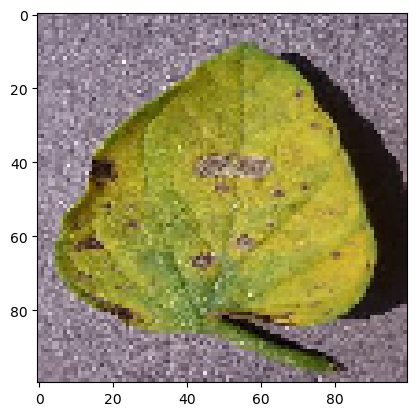

Prediction: Tomato___Leaf_Mold


'Tomato___Leaf_Mold'

In [44]:
predict('t4.jpg')